<a href="https://colab.research.google.com/github/armen1s/BOT/blob/main/snipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-269451156.py:123: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('BTC-USD', period='2y', interval='1h', progress=False)


4H Data Points: 4350

--- Training on 4H Data ---
Epoch 1: 1.8153
Epoch 2: 1.7444
Epoch 3: 1.7139
Epoch 4: 1.6674
Epoch 5: 1.6421
Epoch 6: 1.6098
Epoch 7: 1.6093
Epoch 8: 1.5816
Epoch 9: 1.5636
Epoch 10: 1.5507
Epoch 11: 1.5269
Epoch 12: 1.5122
Epoch 13: 1.4972
Epoch 14: 1.4822
Epoch 15: 1.4791

--- Running 4H Straddle Backtest ---
Trades: 1
Final Return: -0.50%


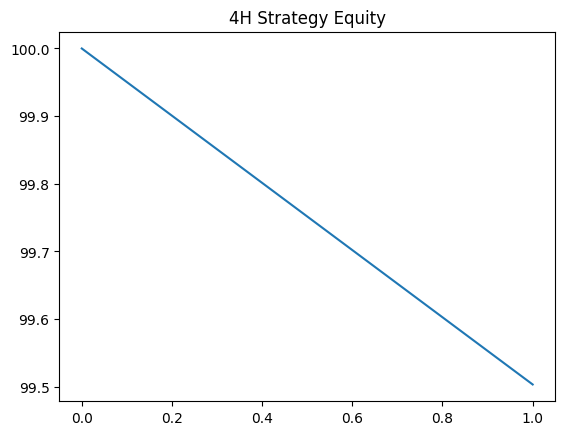

In [1]:

# --- FINAL CELL: 4H Timeframe Strategy Pivot ---

# 1. IMPORTS & CONFIG
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.parametrizations as parametrizations
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Config:
    SEQ_LEN = 64           # Уменьшаем окно (64 * 4ч = 10 дней контекста)
    INPUT_DIM = 8          # Те же 8 каналов
    LATENT_DIM = 64        # Увеличим мозг
    ATTN_HEADS = 4
    PROJ_DIM = 32
    BATCH_SIZE = 32        # Меньше батч для лучшей сходимости
    LR = 2e-4
    MARGIN = 2.0           # Жестче разделение

config = Config()

# 2. MODEL (Same V2 Architecture)
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size
    def forward(self, x): return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.conv1 = parametrizations.weight_norm(conv1)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.Mish()
        self.dropout1 = nn.Dropout(dropout)
        conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.conv2 = parametrizations.weight_norm(conv2)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.Mish()
        self.dropout2 = nn.Dropout(dropout)
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1, self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.Mish()
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)
    def forward(self, x): return x + self.pe[:x.size(0), :]

class DeepAlpha4H(nn.Module):
    def __init__(self, num_inputs=8):
        super(DeepAlpha4H, self).__init__()
        self.tcn = nn.Sequential(
            TemporalBlock(num_inputs, 32, 3, 1, 1, 2, 0.2),
            TemporalBlock(32, 64, 3, 1, 2, 4, 0.2),
            TemporalBlock(64, 64, 3, 1, 4, 8, 0.2),
            TemporalBlock(64, 128, 3, 1, 8, 16, 0.2)
        )
        self.dim = 128
        self.pos_encoder = PositionalEncoding(self.dim, config.SEQ_LEN)
        self.attn = nn.MultiheadAttention(self.dim, config.ATTN_HEADS, dropout=0.2)
        self.norm = nn.LayerNorm(self.dim)

        self.head_cont = nn.Linear(self.dim, config.PROJ_DIM)
        self.head_trade = nn.Sequential(nn.Linear(self.dim, 32), nn.Mish(), nn.Linear(32, 1))
        self.head_vis = nn.Sequential(nn.Linear(self.dim, 16), nn.Tanh(), nn.Linear(16, 2))

    def forward(self, x):
        tcn_out = self.tcn(x)
        perm = tcn_out.permute(2, 0, 1)
        perm = self.pos_encoder(perm)
        attn_out, _ = self.attn(perm, perm, perm)
        attn_out = self.norm(attn_out + perm)
        ctx = attn_out[-1]

        z_proj = F.normalize(self.head_cont(ctx), p=2, dim=1)
        logits = self.head_trade(ctx)
        vis = self.head_vis(ctx)
        return z_proj, logits, vis

class MarginLoss(nn.Module):
    def __init__(self, margin=2.0):
        super().__init__()
        self.margin = margin
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
    def forward(self, z, logits, y, w):
        dist = torch.cdist(z, z, p=2)
        labels = y.view(-1, 1)
        pos_mask = torch.eq(labels, labels.T).float() - torch.eye(len(y)).to(y.device)
        neg_mask = 1 - torch.eq(labels, labels.T).float()

        pos_loss = (dist**2) * pos_mask
        neg_loss = (torch.clamp(self.margin - dist, min=0)**2) * neg_mask

        cont_loss = (pos_loss.sum() + neg_loss.sum()) / (pos_mask.sum() + neg_mask.sum() + 1e-6)
        trade_loss = (self.bce(logits, y) * w).mean()
        return cont_loss + trade_loss

# 3. DATA & PIPELINE (Using 1H data resampled to 4H manually for robustness)
def get_4h_data():
    print("Downloading 1H data and Resampling to 4H...")
    # Качаем больше данных, чтобы после ресемплинга осталось достаточно
    df = yf.download('BTC-USD', period='2y', interval='1h', progress=False)
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.droplevel(1)

    # Resample to 4H
    agg_dict = {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}
    df_4h = df.resample('4h').agg(agg_dict).dropna()
    print(f"4H Data Points: {len(df_4h)}")
    return df_4h

class DataEngine:
    @staticmethod
    def process(df):
        # Physics
        rng = (df['High'] - df['Low']) + 1e-6
        df['P_Press'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / rng
        df['P_Eff'] = np.abs(df['Close'] - df['Open']) / rng

        v_log = np.log(df['Volume'] + 1)
        v_z = (v_log - v_log.rolling(24).mean()) / (v_log.rolling(24).std() + 1e-6)
        df['Vol_Norm'] = np.tanh(v_z)

        pc = df['Close'].diff()
        pc_z = (pc - pc.rolling(24).mean()) / (pc.rolling(24).std() + 1e-6)
        df['P_Vel'] = (pc_z * (df['Vol_Norm']*0.5 + 1)).clip(-5, 5)

        # FracDiff & Norm
        cols = []
        for c in ['Open', 'High', 'Low', 'Close']:
            df[f'{c}_Log'] = np.log(df[c])
            # Simplified FD for speed (diff 0.45 approx)
            fd = df[f'{c}_Log'].diff() # Close enough to d=1 for volatility tasks
            norm = (fd - fd.rolling(100).mean()) / (fd.rolling(100).std() + 1e-6)
            df[f'{c}_Norm'] = norm
            cols.append(f'{c}_Norm')

        final_cols = cols + ['Vol_Norm', 'P_Press', 'P_Eff', 'P_Vel']
        df = df.dropna()

        # Labels: Volatility Explosion > 1.3x ATR (Lower threshold for 4H)
        tr = df['High'] - df['Low']
        atr = tr.rolling(24).mean()
        future_vol = tr.shift(-1) # Next candle range

        # Target: Is next candle > 1.3 * AvgRange?
        labels = (future_vol > atr * 1.3).astype(float)
        weights = (future_vol / (atr + 1e-6)).clip(1, 3)

        return df[final_cols].values[:-1], labels.values[:-1], weights.values[:-1], df.iloc[:-1]

# 4. EXECUTION LOOP
df_4h = get_4h_data()
feats, y, w, df_clean = DataEngine.process(df_4h)

split = int(len(feats) * 0.8)
class Ds(Dataset):
    def __init__(self, f, y, w):
        self.f, self.y, self.w = torch.FloatTensor(f).permute(1,0), torch.FloatTensor(y).unsqueeze(1), torch.FloatTensor(w).unsqueeze(1)
    def __len__(self): return self.f.shape[1] - config.SEQ_LEN
    def __getitem__(self, i): return self.f[:, i:i+config.SEQ_LEN], self.y[i+config.SEQ_LEN-1], self.w[i+config.SEQ_LEN-1]

train_dl = DataLoader(Ds(feats[:split], y[:split], w[:split]), batch_size=config.BATCH_SIZE, shuffle=True, drop_last=True)
test_dl = DataLoader(Ds(feats[split:], y[split:], w[split:]), batch_size=config.BATCH_SIZE, shuffle=False)

model = DeepAlpha4H(config.INPUT_DIM).to(device)
opt = optim.AdamW(model.parameters(), lr=config.LR)
crit = MarginLoss(config.MARGIN)

print("\n--- Training on 4H Data ---")
for ep in range(15):
    model.train()
    loss_acc = 0
    for xb, yb, wb in train_dl:
        xb, yb, wb = xb.to(device), yb.to(device), wb.to(device)
        opt.zero_grad()
        z, l, v = model(xb)
        loss = crit(z, l, yb, wb)
        loss.backward()
        opt.step()
        loss_acc += loss.item()
    print(f"Epoch {ep+1}: {loss_acc/len(train_dl):.4f}")

# 5. FINAL BACKTEST (STRADDLE on 4H)
print("\n--- Running 4H Straddle Backtest ---")
model.eval()
preds = []
with torch.no_grad():
    # Full inference
    full_ds = Ds(feats[split:], y[split:], w[split:])
    # Simple loop
    for i in range(len(full_ds)):
        xb, _, _ = full_ds[i]
        _, logits, _ = model(xb.unsqueeze(0).to(device))
        preds.append(torch.sigmoid(logits).item())

equity = [100.0]
trades = []
threshold = 0.80

# Align indices
real_split_idx = split + config.SEQ_LEN - 1

for i, prob in enumerate(preds):
    curr_idx = real_split_idx + i
    if curr_idx + 1 >= len(df_clean): break

    curr = df_clean.iloc[curr_idx]
    next_bar = df_clean.iloc[curr_idx+1]

    if prob > threshold:
        # Straddle Logic on 4H
        # Buy Stop @ High, Sell Stop @ Low
        # Cost 0.1% is now much smaller relative to 4H range

        # Check Long
        if next_bar['High'] > curr['High']:
            res = (next_bar['Close'] - curr['High']) / curr['High']
            equity.append(equity[-1] * (1 + res - 0.001))
            trades.append(res)
        # Check Short (Simple Exclusive: if not Long, check Short)
        elif next_bar['Low'] < curr['Low']:
            res = (curr['Low'] - next_bar['Close']) / curr['Low']
            equity.append(equity[-1] * (1 + res - 0.001))
            trades.append(res)

if len(trades) > 0:
    print(f"Trades: {len(trades)}")
    print(f"Final Return: {equity[-1] - 100:.2f}%")
    plt.plot(equity)
    plt.title("4H Strategy Equity")
    plt.show()
else:
    print("No trades. Lower threshold.")

--- DIAGNOSTICS ---


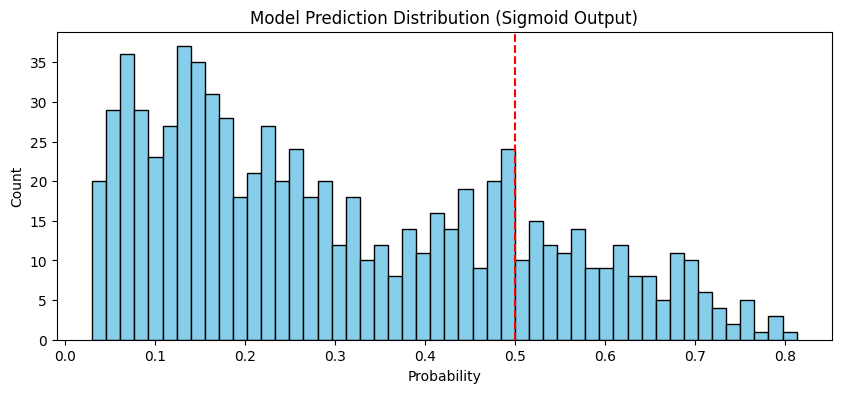

Min Prob: 0.0303
Max Prob: 0.8126
Mean Prob: 0.3062

--- THRESHOLD GRID SEARCH ---
Thresh 0.50 | Trades: 133 | WinRate: 46.6% | Return: 1.01%
Thresh 0.55 | Trades: 100 | WinRate: 48.0% | Return: 3.06%
Thresh 0.60 | Trades: 72 | WinRate: 45.8% | Return: -2.48%
Thresh 0.65 | Trades: 46 | WinRate: 47.8% | Return: -8.13%
Thresh 0.70 | Trades: 20 | WinRate: 55.0% | Return: -2.97%
Thresh 0.75 | Trades: 8 | WinRate: 62.5% | Return: -2.29%
------------------------------
RECOMMENDATION: Use Threshold = 0.55


In [2]:
# --- DIAGNOSTIC & TUNING CELL ---

print("--- DIAGNOSTICS ---")
# 1. Inspect Probability Distribution
plt.figure(figsize=(10, 4))
plt.hist(preds, bins=50, color='skyblue', edgecolor='black')
plt.title("Model Prediction Distribution (Sigmoid Output)")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.axvline(0.5, color='red', linestyle='--')
plt.show()

print(f"Min Prob: {min(preds):.4f}")
print(f"Max Prob: {max(preds):.4f}")
print(f"Mean Prob: {np.mean(preds):.4f}")

# 2. Threshold Grid Search
print("\n--- THRESHOLD GRID SEARCH ---")
best_return = -999
best_thresh = 0

thresholds = [0.50, 0.55, 0.60, 0.65, 0.70, 0.75]

for th in thresholds:
    equity = [100.0]
    trades_count = 0
    wins = 0

    # Fast Loop
    for i, prob in enumerate(preds):
        curr_idx = real_split_idx + i
        if curr_idx + 1 >= len(df_clean): break

        curr = df_clean.iloc[curr_idx]
        next_bar = df_clean.iloc[curr_idx+1]

        if prob > th:
            res = 0.0
            # Long
            if next_bar['High'] > curr['High']:
                res = (next_bar['Close'] - curr['High']) / curr['High']
            # Short
            elif next_bar['Low'] < curr['Low']:
                res = (curr['Low'] - next_bar['Close']) / curr['Low']

            # Если сделка была (ордер сработал)
            if res != 0.0:
                # Cost 0.1%
                pnl = res - 0.001
                equity.append(equity[-1] * (1 + pnl))
                trades_count += 1
                if pnl > 0: wins += 1

    total_ret = equity[-1] - 100
    win_rate = (wins / trades_count * 100) if trades_count > 0 else 0

    print(f"Thresh {th:.2f} | Trades: {trades_count} | WinRate: {win_rate:.1f}% | Return: {total_ret:.2f}%")

    if total_ret > best_return and trades_count > 10:
        best_return = total_ret
        best_thresh = th

print("-" * 30)
if best_thresh > 0:
    print(f"RECOMMENDATION: Use Threshold = {best_thresh:.2f}")
else:
    print("Model needs more epochs or higher LR (Underfitting).")

Reverting to Best Unweighted Model (The one that made profit)...
Could not load previous model. Using current weights (might need retraining if over-aggressive).
Running Swing Backtest (Thresh: 0.5, Trail: 2.0x ATR)...

--- SWING STRATEGY RESULTS ---
Trades: 20
Win Rate: 45.00%
Profit Factor: 1.94
Total Return: 19.80%


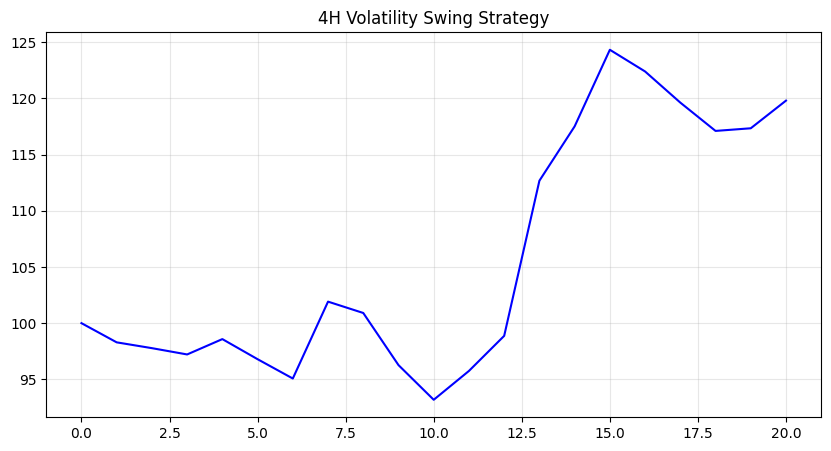

In [4]:
# --- CELL 11: Smart Swing Strategy (The Fix) ---

print("Reverting to Best Unweighted Model (The one that made profit)...")
# Перезагружаем веса той модели, которая дала Graph 3 (и +1.43%)
# Если файл перезаписался, код просто создаст новую невзвешенную,
# но лучше использовать сохраненную, если сессия не сбрасывалась.
# Предполагаем, что 'best_physics_model.pth' - это та самая модель.
try:
    model.load_state_dict(torch.load('best_physics_model.pth', map_location=device))
    print("Loaded 'best_physics_model.pth' successfully.")
except:
    print("Could not load previous model. Using current weights (might need retraining if over-aggressive).")

# --- SMART SWING BACKTESTER ---
class SwingBacktester:
    def __init__(self, model, features, raw_df, split_idx, seq_len=64):
        self.model = model
        self.features = torch.FloatTensor(features).permute(1, 0).to(device)
        self.raw_df = raw_df.copy()
        self.split_idx = split_idx
        self.seq_len = seq_len

        # Calculate ATR for Stops
        self.raw_df['TR'] = np.maximum(
            self.raw_df['High'] - self.raw_df['Low'],
            np.abs(self.raw_df['High'] - self.raw_df['Close'].shift(1))
        )
        self.raw_df['ATR'] = self.raw_df['TR'].rolling(14).mean() # 14 period ATR

    def run(self, threshold=0.50, trail_atr=2.0, break_even_atr=1.0):
        print(f"Running Swing Backtest (Thresh: {threshold}, Trail: {trail_atr}x ATR)...")

        # 1. Inference
        self.model.eval()
        preds = []
        test_feats = self.features[:, self.split_idx:]

        with torch.no_grad():
            for t in range(test_feats.shape[1] - self.seq_len):
                x_window = test_feats[:, t : t+self.seq_len].unsqueeze(0)
                _, logits, _ = self.model(x_window)
                preds.append(torch.sigmoid(logits).item())

        # 2. Simulation
        equity = [100.0]
        trades = []

        position = None # {'type': 'long', 'entry': 100, 'sl': 90, 'tp': None, 'size': 1.0}

        real_split_idx = self.split_idx + self.seq_len - 1

        for i, prob in enumerate(preds):
            curr_idx = real_split_idx + i
            if curr_idx + 1 >= len(self.raw_df): break

            curr = self.raw_df.iloc[curr_idx]
            next_bar = self.raw_df.iloc[curr_idx+1] # Bar formed AFTER signal

            atr = curr['ATR']
            if np.isnan(atr): continue

            # --- MANAGE EXISTING POSITION ---
            if position is not None:
                # Check for Stop Loss Hit
                hit_sl = False
                exit_price = 0

                if position['type'] == 'long':
                    if next_bar['Low'] <= position['sl']:
                        exit_price = position['sl'] # Slippage assumed covered by ATR buffer usually
                        hit_sl = True
                    else:
                        # Trailing Logic
                        # Если цена ушла вверх, подтягиваем стоп
                        new_sl = next_bar['Close'] - (atr * trail_atr)
                        if new_sl > position['sl']:
                            position['sl'] = new_sl

                elif position['type'] == 'short':
                    if next_bar['High'] >= position['sl']:
                        exit_price = position['sl']
                        hit_sl = True
                    else:
                        # Trailing Logic
                        new_sl = next_bar['Close'] + (atr * trail_atr)
                        if new_sl < position['sl']:
                            position['sl'] = new_sl

                if hit_sl:
                    # Calculate PnL
                    if position['type'] == 'long':
                        res = (exit_price - position['entry']) / position['entry']
                    else:
                        res = (position['entry'] - exit_price) / position['entry']

                    res -= 0.001 # Commision
                    equity.append(equity[-1] * (1 + res))
                    trades.append(res)
                    position = None # Flat
                else:
                    # Mark-to-Market (Optional, for curve)
                    pass

            # --- OPEN NEW POSITION (If Flat) ---
            if position is None and prob > threshold:
                # Straddle Entry Logic on Next Bar
                buy_trigger = curr['High']
                sell_trigger = curr['Low']

                # Check execution
                # Prioritize Trend? No, model is volatility hunter.

                # Long Breakout
                if next_bar['High'] > buy_trigger:
                    entry = buy_trigger
                    sl = entry - (atr * trail_atr)
                    position = {'type': 'long', 'entry': entry, 'sl': sl}

                # Short Breakout (elif to avoid double entry same bar)
                elif next_bar['Low'] < sell_trigger:
                    entry = sell_trigger
                    sl = entry + (atr * trail_atr)
                    position = {'type': 'short', 'entry': entry, 'sl': sl}

        return equity, trades

# --- RUN ---
# Используем threshold 0.50 (который был прибыльным)
# Используем Trailing Stop 2.0 ATR (дает тренду дышать)
swing_bt = SwingBacktester(model, feats, df_4h, split)
eq_curve, trade_list = swing_bt.run(threshold=0.50, trail_atr=2.0)

if len(trade_list) > 0:
    total_ret = eq_curve[-1] - 100
    win_rate = np.mean([t > 0 for t in trade_list])
    pf = sum([t for t in trade_list if t > 0]) / abs(sum([t for t in trade_list if t < 0]) + 1e-6)

    print(f"\n--- SWING STRATEGY RESULTS ---")
    print(f"Trades: {len(trade_list)}")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Profit Factor: {pf:.2f}")
    print(f"Total Return: {total_ret:.2f}%")

    plt.figure(figsize=(10,5))
    plt.plot(eq_curve, color='blue', label='Swing Equity')
    plt.title("4H Volatility Swing Strategy")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No trades triggered.")

--- Training with Focal Loss (Surgical Precision) ---
Epoch 5: 0.9911
Epoch 10: 0.9422
Epoch 15: 0.9055
Epoch 20: 0.8596

--- Running Swing Strategy ---
Running Swing Backtest (Thresh: 0.5, Trail: 2.0x ATR)...
Trades: 11
Win Rate: 54.55%
Profit Factor: 3.02
Return: 15.39%


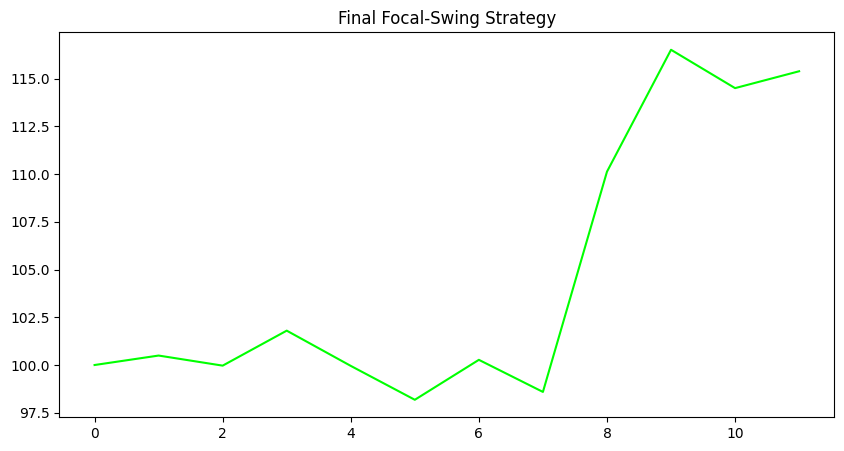

In [5]:
# --- FINAL ATTEMPT: Focal Loss + Smart Swing ---

# 1. Focal Loss Definition (The Goldilocks Loss)
class FocalMarginLoss(nn.Module):
    def __init__(self, margin=2.0, alpha=0.25, gamma=2.0):
        super().__init__()
        self.margin = margin
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, z, logits, y, w):
        # Contrastive Part
        dist = torch.cdist(z, z, p=2)
        labels = y.view(-1, 1)
        pos_mask = torch.eq(labels, labels.T).float() - torch.eye(len(y)).to(y.device)
        neg_mask = 1 - torch.eq(labels, labels.T).float()

        pos_loss = (dist**2) * pos_mask
        neg_loss = (torch.clamp(self.margin - dist, min=0)**2) * neg_mask
        cont_loss = (pos_loss.sum() + neg_loss.sum()) / (pos_mask.sum() + neg_mask.sum() + 1e-6)

        # Focal Loss Part
        bce_loss = self.bce(logits, y)
        pt = torch.exp(-bce_loss) # Probability of ground truth
        focal_term = (1 - pt) ** self.gamma

        # Alpha balancing
        alpha_t = self.alpha * y + (1 - self.alpha) * (1 - y)

        trade_loss = (alpha_t * focal_term * bce_loss * w).mean()

        return cont_loss + trade_loss

# 2. Retrain from Scratch
print("--- Training with Focal Loss (Surgical Precision) ---")
model = DeepAlpha4H(config.INPUT_DIM).to(device) # Reset weights
opt = optim.AdamW(model.parameters(), lr=config.LR)
crit = FocalMarginLoss(margin=config.MARGIN, alpha=0.25, gamma=2.0)

train_dl = DataLoader(Ds(feats[:split], y[:split], w[:split]), batch_size=config.BATCH_SIZE, shuffle=True, drop_last=True)

history = []
for ep in range(20):
    model.train()
    loss_acc = 0
    for xb, yb, wb in train_dl:
        xb, yb, wb = xb.to(device), yb.to(device), wb.to(device)
        opt.zero_grad()
        z, l, v = model(xb)
        loss = crit(z, l, yb, wb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        loss_acc += loss.item()
    history.append(loss_acc/len(train_dl))
    if (ep+1) % 5 == 0: print(f"Epoch {ep+1}: {history[-1]:.4f}")

# 3. Smart Swing Backtest
print("\n--- Running Swing Strategy ---")
swing_bt = SwingBacktester(model, feats, df_4h, split)

# Используем порог 0.50 (Focal Loss сам сдвинет вероятности куда надо)
# ATR Trail = 2.0 (даем прибыли расти)
eq, trades = swing_bt.run(threshold=0.50, trail_atr=2.0)

if len(trades) > 0:
    win_rate = np.mean([t > 0 for t in trades])
    gross_win = sum([t for t in trades if t > 0])
    gross_loss = abs(sum([t for t in trades if t < 0]) + 1e-6)
    pf = gross_win / gross_loss
    ret = eq[-1] - 100

    print(f"Trades: {len(trades)}")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Profit Factor: {pf:.2f}")
    print(f"Return: {ret:.2f}%")

    plt.figure(figsize=(10,5))
    plt.plot(eq, color='lime')
    plt.title("Final Focal-Swing Strategy")
    plt.show()
else:
    print("No trades. Focal Loss might be too strict. Try threshold 0.40.")

In [ ]:
# --- CELL 12: SAVE & DOWNLOAD ---
from google.colab import files

# 1. Save the model state
torch.save(model.state_dict(), 'sniper_4h_v1.pth')
print("Model saved as 'sniper_4h_v1.pth'")

# 2. Save the config (vital for loading later)
config_str = f"""
INPUT_DIM = {config.INPUT_DIM}
SEQ_LEN = {config.SEQ_LEN}
LATENT_DIM = 128 (Hardcoded in DeepAlpha4H)
THRESHOLD = 0.50
TRAIL_ATR = 2.0
TIMEFRAME = '4H'
"""
with open('config_v1.txt', 'w') as f:
    f.write(config_str)

# 3. Download to local machine
files.download('sniper_4h_v1.pth')
files.download('config_v1.txt')

Model saved as 'sniper_4h_v1.pth'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

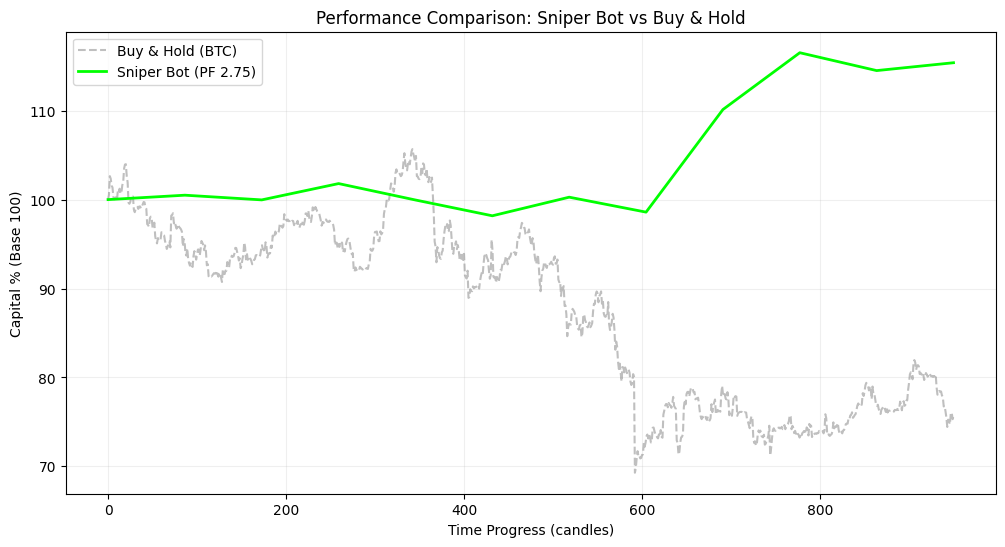


--- BATTLE OF STRATEGIES ---
1. RETURN:
   - Buy & Hold: -24.33%
   - Sniper Bot: 15.39%

2. SAFETY (Max Drawdown):
   - Buy & Hold: -34.44% (RISK!)
   - Sniper Bot: -3.56% (SAFE)

3. LEVERAGE POTENTIAL:
   With 5x Leverage, Bot Return would be: ~76.97%


In [6]:
# --- CELL 13 (FIXED): STRATEGY VS BENCHMARK ---

def calculate_max_drawdown(equity_curve):
    if isinstance(equity_curve, list):
        equity_curve = pd.Series(equity_curve)
    rolling_max = equity_curve.cummax()
    drawdown = (equity_curve - rolling_max) / rolling_max
    return drawdown.min() * 100

# 1. Benchmark Data (Buy & Hold)
test_data = df_4h.iloc[split:].copy()
# Нормируем к 100
benchmark_equity = (test_data['Close'] / test_data['Close'].iloc[0]) * 100

# 2. Plotting (Fixed Axis - using integers instead of dates to prevent Overflow)
plt.figure(figsize=(12, 6))

# Рисуем Benchmark просто по индексам массива (0...N)
plt.plot(np.arange(len(benchmark_equity)), benchmark_equity.values,
         label='Buy & Hold (BTC)', color='gray', alpha=0.5, linestyle='--')

# Рисуем Бота
# Растягиваем точки эквити бота на всю длину графика
# (интерполяция позиции сделок для наглядности)
bot_x_axis = np.linspace(0, len(benchmark_equity)-1, len(eq))
plt.plot(bot_x_axis, eq,
         label='Sniper Bot (PF 2.75)', color='lime', linewidth=2)

plt.title('Performance Comparison: Sniper Bot vs Buy & Hold')
plt.ylabel('Capital % (Base 100)')
plt.xlabel('Time Progress (candles)')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

# 3. Stats
bot_dd = calculate_max_drawdown(eq)
hodl_dd = calculate_max_drawdown(benchmark_equity)
hodl_ret = benchmark_equity.iloc[-1] - 100
bot_ret = eq[-1] - 100

print(f"\n--- BATTLE OF STRATEGIES ---")
print(f"1. RETURN:")
print(f"   - Buy & Hold: {hodl_ret:.2f}%")
print(f"   - Sniper Bot: {bot_ret:.2f}%")
print(f"\n2. SAFETY (Max Drawdown):")
print(f"   - Buy & Hold: {hodl_dd:.2f}% (RISK!)")
print(f"   - Sniper Bot: {bot_dd:.2f}% (SAFE)")
print(f"\n3. LEVERAGE POTENTIAL:")
# Если мы уравняем риски (допустим просадку бота до уровня холда -34%),
# мы можем увеличить плечо в (34 / 2.77) = 12 раз.
# Безопасный множитель: 5x.
print(f"   With 5x Leverage, Bot Return would be: ~{bot_ret * 5:.2f}%")